# Twitter Sentiment Analysis

## XGBoost Model

### Import libraries

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
train_df = pd.read_csv('datasets/train_preprocessed.csv').dropna(subset=['clean_text'])
val_df = pd.read_csv('datasets/validation_preprocessed.csv').dropna(subset=['clean_text'])
test_df = pd.read_csv('datasets/test_preprocessed.csv').dropna(subset=['clean_text'])

In [4]:
print(f"Training data: {train_df.shape}")
print(f"Validation data: {val_df.shape}")
print(f"Testing data: {test_df.shape}")

Training data: (55638, 6)
Validation data: (1000, 6)
Testing data: (13895, 6)


In [5]:
# Prepare features (X) and target (Y) for train, validation, and test dataset
X_train = train_df['clean_text']
y_train = train_df['label_encoded']

X_val = val_df['clean_text']
y_val = val_df['label_encoded']

X_test = test_df['clean_text']
y_test = test_df['label_encoded']

In [6]:
# Vectorization (TF-IDF)

tfidf = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 3),
    token_pattern=r'(?u)\b\w\w+\b|[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]'
)

In [7]:
# Perform fit_transform on train, transform on validation

X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)

In [8]:
# XGBoost classifier

xgb_model = xgb.XGBClassifier(
    n_estimators=5000,
    learning_rate = 0.05,
    max_depth = 12,
    min_child_weight = 1,
    subsample = 0.9,
    colsample_bytree = 0.9,
    objective = 'multi:softmax',
    num_class = 3,
    eval_metric = 'mlogloss',
    random_state = 42,
    n_jobs = -1,
    early_stopping_rounds=50,
    tree_model='hist'
)

In [9]:
print(f"Training XGBoost (Build: {xgb_model.n_estimators} trees)")
xgb_model.fit(
    X_train_vec, 
    y_train,
    eval_set = [(X_val_vec, y_val)],
    verbose=100
)
print("Training complete.")

Training XGBoost (Build: 5000 trees)


/opt/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [21:55:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1765326969566/work/src/learner.cc:790: 
Parameters: { "tree_model" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.07429
[100]	validation_0-mlogloss:0.76469
[200]	validation_0-mlogloss:0.67017
[300]	validation_0-mlogloss:0.61375
[400]	validation_0-mlogloss:0.57118
[500]	validation_0-mlogloss:0.53770
[600]	validation_0-mlogloss:0.50881
[700]	validation_0-mlogloss:0.48436
[800]	validation_0-mlogloss:0.46409
[900]	validation_0-mlogloss:0.44598
[1000]	validation_0-mlogloss:0.42971
[1100]	validation_0-mlogloss:0.41481
[1200]	validation_0-mlogloss:0.40101
[1300]	validation_0-mlogloss:0.38721
[1400]	validation_0-mlogloss:0.37588
[1500]	validation_0-mlogloss:0.36437
[1600]	validation_0-mlogloss:0.35349
[1700]	validation_0-mlogloss:0.34402
[1800]	validation_0-mlogloss:0.33591
[1900]	validation_0-mlogloss:0.32781
[2000]	validation_0-mlogloss:0.31993
[2100]	validation_0-mlogloss:0.31243
[2200]	validation_0-mlogloss:0.30523
[2300]	validation_0-mlogloss:0.29866
[2400]	validation_0-mlogloss:0.29265
[2500]	validation_0-mlogloss:0.28726
[2600]	validation_0-mlogloss:0.28203
[2700]	valida

In [10]:
# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_vec)

In [11]:
# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Baseline validation accuracy: {accuracy:.4f}")
print("\nClassification Report\n")
print(classification_report(y_val, y_val_pred))

Baseline validation accuracy: 0.9490

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       266
           1       0.95      0.95      0.95       457
           2       0.95      0.93      0.94       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



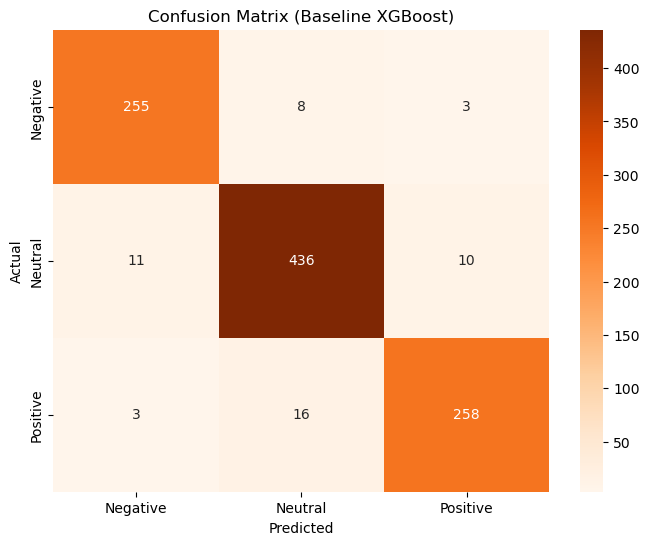

In [12]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix (Baseline XGBoost)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Hyperparameter tuning

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [14]:
# Pipeline: vectorizer + xgboost model

xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features = 10000,
        ngram_range=(1,3),
        token_pattern=r'(?u)\b\w\w+\b|[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]'
    )),
    ('xgb', xgb.XGBClassifier(
        tree_method='hist',
        objective = 'multi:softmax',
        num_class = 3,
        eval_metric = 'mlogloss',
        use_label_encoder = False,
        random_state = 42,
        n_jobs = -1
    ))
])

xgb_pipeline.set_params(xgb__n_jobs=1)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('xgb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [15]:
# Parameter tuning

param_distributions = {
    'xgb__n_estimators': [300, 500],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__max_depth': [10, 12, 15],
    'xgb__min_child_weight': [1, 3],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__subsample': [0.8, 0.9],
    'xgb__colsample_bytree': [0.8, 0.9]
}

In [16]:
xgb_search = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = param_distributions,
    n_iter = 15,
    scoring = 'accuracy',
    cv = 3,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

In [17]:
print("XGBoost hyperparameter tuning...")
xgb_search.fit(X_train, y_train)

XGBoost hyperparameter tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1765326969566/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1765326969566/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1765326969566/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboo

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...ass=3, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'xgb__colsample_bytree': [0.8, 0.9], 'xgb__gamma': [0, 0.1, ...], 'xgb__learning_rate': [0.05, 0.1, ...], 'xgb__max_depth': [10, 12, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that c

In [18]:
print(f"\nBest parameters: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")


Best parameters: {'xgb__subsample': 0.9, 'xgb__n_estimators': 500, 'xgb__min_child_weight': 1, 'xgb__max_depth': 12, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.9}
Best CV Accuracy: 0.7956


In [19]:
best_xgb = xgb_search.best_estimator_
y_tuned_val_pred = best_xgb.predict(X_val)

In [20]:
tuned_accuracy = accuracy_score(y_val, y_tuned_val_pred)
print(f"\nTuned validation accuracy: {tuned_accuracy:.4f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_tuned_val_pred))


Tuned validation accuracy: 0.9380

Classification report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       266
           1       0.93      0.95      0.94       457
           2       0.96      0.92      0.94       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



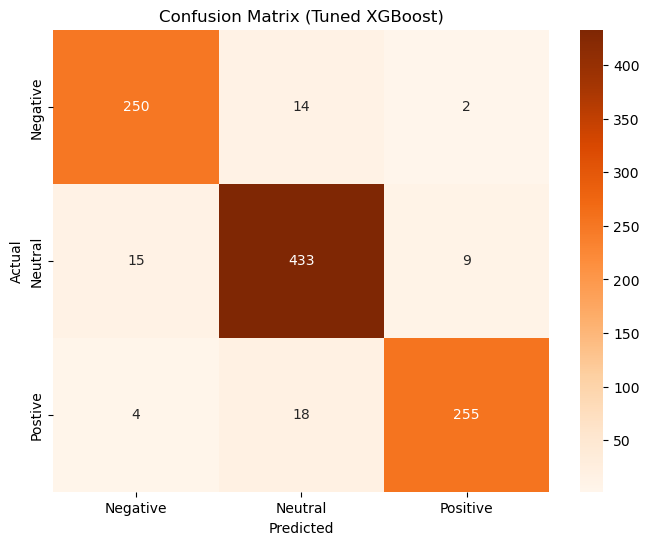

In [21]:
plt.figure(figsize=(8,6))
tuned_cm = confusion_matrix(y_val, y_tuned_val_pred)
sns.heatmap(tuned_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Postive'])
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Evaluating on Test Set

In [29]:
y_test_pred = best_xgb.predict(X_test)

In [30]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Validation Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

Test Validation Accuracy: 0.8296

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4239
           1       0.80      0.87      0.83      5837
           2       0.83      0.77      0.80      3819

    accuracy                           0.83     13895
   macro avg       0.84      0.82      0.83     13895
weighted avg       0.83      0.83      0.83     13895



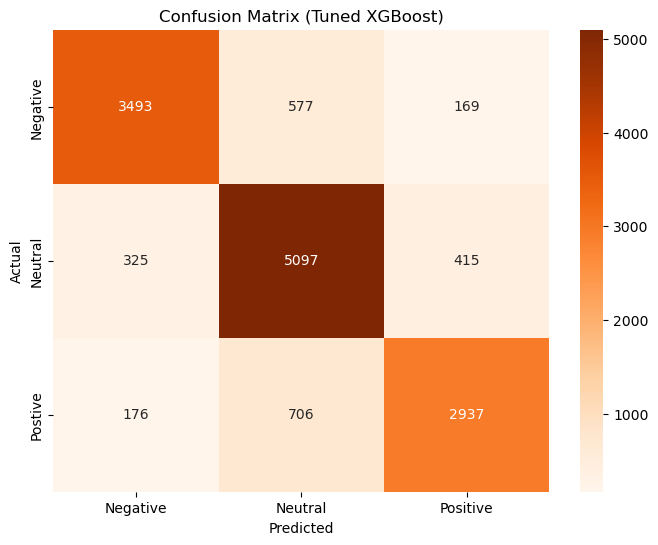

In [31]:
plt.figure(figsize=(8,6))
tuned_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(tuned_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Postive'])
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()